# Домашнее задание 7

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 7 апреля. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_7

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим "распределенную" задачу минимизации:
\begin{equation}
\min_{x \in \mathbb{R}^d} f(x) = \frac{1}{n} \sum\limits_{i=1}^n f_i(x) = \frac{1}{2n} \sum\limits_{i=1}^n x^T A_i x - b^T_i x,
\end{equation}
где $n = 10$, в качестве матриц $\{A_i\}_{i=1}^n$ - случайные матрицы с $L =1000$, $\mu = 1$, $d = 100$, $\{b_i\}_{i=1}^n$ - так же случайные векторы.

__(а)__ Для такой задачи симулируем распределенное решение (вычисления на 1 компьютере, без распараллеливания). 
Реализуйте обычный распределенный градиентый спуск с операторами сжатия. Сжимайте информацию только от устройств к серверу. Используйте операторы сжатия $\text{Rand}1\%$, $\text{Rand}5\%$, $\text{Rand}10\%$, $\text{Rand}20\%$. Для каждого случая подберите шаг $\gamma$ для наилучшей сходимости, постройте сравнительный график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число "переданной информации" от устройств к серверу). Сделайте вывод.

Для 1% шаг $1/5L$
Для 5 я не смог найти точно шаг. $1/4L$ и $1/5L$ выдают одинаковые результаты. На графике строил оба 
Для 10 шаг $1/4L$
Для 20 шаг $1/4L$

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
import math 
import time
%matplotlib inline
import scipy.stats

In [2]:
def generate_matrix(d, m, L):
    D = (L-m)*np.random.random_sample(d) + m
    #print(D)
    D[0] = d
    D[1] = m
    D = np.diag(D)
    S = scipy.stats.ortho_group.rvs(d) 
    #print(S)
    return S@D@S.T

L = 1000
mu = 1
d = 100
sigma = 10
m = 0
N = 10000
n=10

masA=[]
masB=[]
for i in range(n):
    masA.append(generate_matrix(d, mu, L))
    masB.append(np.random.normal(m, sigma, d))

In [3]:
#def compression_Rand(compression_rate, vec0):
    #D = len(vec0)
    #pos = np.arange(D)
    #np.random.shuffle(pos)
    #pos = pos[:compression_rate]
    #return vec0[pos]*D/compression_rate

def gradient_descent(gradient, x_0, learning_rate, iter_number):
    x = x_0
    for _ in range(iter_number):
        gr = gradient(x)
        x = x - learning_rate * gr
        criterion.append(np.linalg.norm(gr))
    return x



In [4]:
def grad_f(A, b, x):
    return A@x-b

criterion1 = []
def grad_descent_distr(x_0, learning_rate, iter_number, k):
    x = x_0
    for _ in range(iter_number):
        pos = np.arange(d)
        np.random.shuffle(pos)
        pos = pos[:k]
        grad, criterion =  grad_descent_distr_step(x, learning_rate, iter_number, pos)
            
        x = x - learning_rate * grad 
        criterion1.append(np.linalg.norm(criterion))
    return x



def grad_descent_distr_step(x, learning_rate, iter_number,pos):
    grad = np.zeros(d)
    criterion = np.zeros(d)
    for i in range(n):
        criterion_i = grad_f(masA[i],masB[i],x)
        criterion +=criterion_i
        grad_i = np.zeros(d)
        grad_i[pos] = criterion_i[pos]
        grad += grad_i
    return grad, criterion


Text(0.5, 0, 'Передачи')

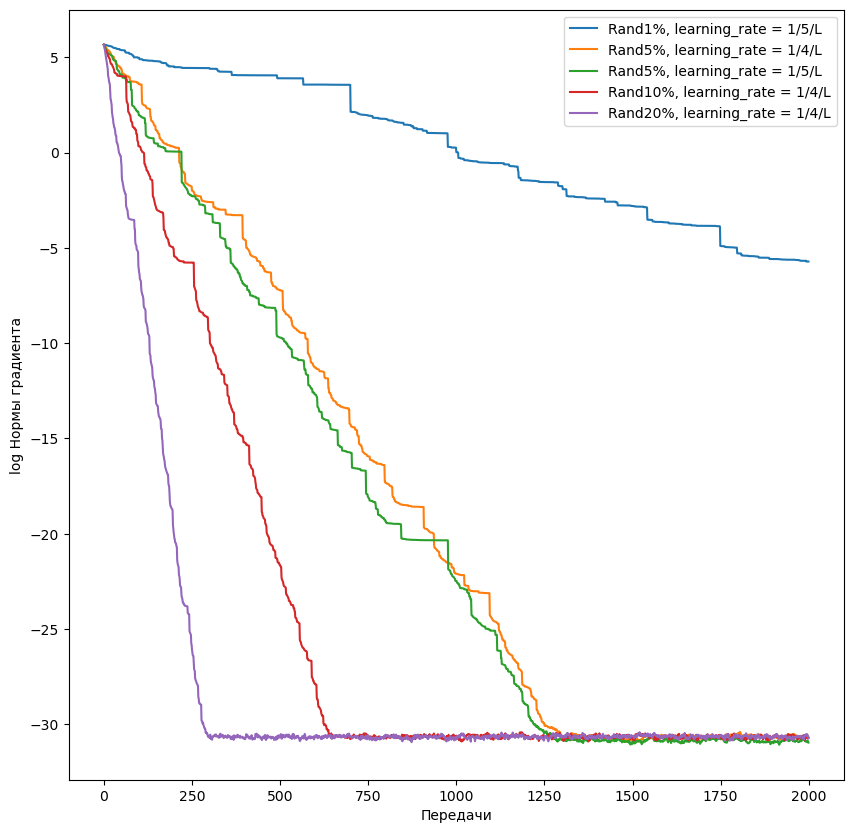

In [5]:
plt.figure(figsize=(10, 10))

iter_number = 2000

criterion1 = []
x = grad_descent_distr([0]*d, 1/5/L, iter_number, 1)
plt.plot(range(iter_number), np.log(criterion1),  label = f'Rand1%, learning_rate = 1/5/L')

criterion1 = []
x = grad_descent_distr([0]*d, 1/4/L, iter_number, 5)
plt.plot(range(iter_number), np.log(criterion1),  label = f'Rand5%, learning_rate = 1/4/L')

criterion1 = []
x = grad_descent_distr([0]*d, 1/5/L, iter_number, 5)
plt.plot(range(iter_number), np.log(criterion1),  label = f'Rand5%, learning_rate = 1/5/L')

criterion1 = []
x = grad_descent_distr([0]*d, 1/4/L, iter_number, 10)
plt.plot(range(iter_number), np.log(criterion1),  label = f'Rand10%, learning_rate = 1/4/L')

criterion1 = []
x = grad_descent_distr([0]*d, 1/4/L, iter_number, 20)
plt.plot(range(iter_number), np.log(criterion1),  label = f'Rand20%, learning_rate = 1/4/L')


plt.legend()

plt.ylabel('log Нормы градиента')
plt.xlabel('Передачи')

$Rand20\%$ быстрее всех

__(б)__ Теперь будем использовать в качестве операторов сжатия $\text{Top}10\%$. Сжимайте информацию только от устройств к серверу. Используйте два метода: обычный распределенный градиентный спуск с операторами сжатия, также распределенный градиентный спуск с техникой компесации ошибки (error feedback - смотри Алгоритм 1 из [статьи](https://arxiv.org/abs/2002.12410)). Для каждого метода подберите шаг $\gamma$ для наилучшей сходимости, постройте сравнительный график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число итераций/коммуникаций). Сделайте вывод.

In [6]:
criterion2 = []

def Gradient_descent_Top(x_0, learning_rate, iter_number, k):
    x = x_0
    pos = np.argpartition(np.zeros(d), -k)
    pos = pos[-k:]
    for i in range(iter_number):
        
        grad, criterion =  Gradient_descent_Top_step(x, learning_rate, iter_number, pos)
        
        x = x - learning_rate * grad 
        #print(x)
        criterion2.append(np.linalg.norm(criterion))
        pos = np.argpartition(np.abs(criterion), -k)
        pos = pos[-k:]
    return x

def Gradient_descent_Top_step(x, learning_rate, iter_number,pos):
    grad = np.zeros(d)
    criterion = np.zeros(d)
    for i in range(n):
        criterion_i = grad_f(masA[i],masB[i],x)
        criterion +=criterion_i
        grad_i = np.zeros(d)
        grad_i[pos] = criterion_i[pos]
        grad += grad_i
    return grad, criterion


criterion3 = []
errors  = np.zeros((n, d))
def error_feedback(x_0, learning_rate, iter_number, k):
    x = x_0
    pos = np.argpartition(np.zeros(d), -k)
    
    for i in range(iter_number):
        grad = np.zeros(d)
        criterion = np.zeros(d)
        
        grad, criterion =  ef_step(x, learning_rate, iter_number, pos)
        
        x = x - learning_rate * grad 
        criterion3.append(np.linalg.norm(criterion))
    pos = np.argpartition(np.abs(criterion), -k)
    pos = pos[-k:]
    criterion3.append(np.linalg.norm(criterion))
    return x
    
def ef_step(x, learning_rate, iter_number, pos):
    grad = np.zeros(d)
    criterion = np.zeros(d)
    for i in range(n):
        criterion_i = grad_f(masA[i], masB[i], x)
        criterion += criterion_i

        grad_i = np.zeros(d)
        grad_i[pos] = (errors[i] + learning_rate* criterion_i)[pos]
        grad += grad_i
        errors[i] = errors[i] + learning_rate * criterion_i - grad_i
    return (grad, criterion)


Text(0.5, 0, 'Передачи')

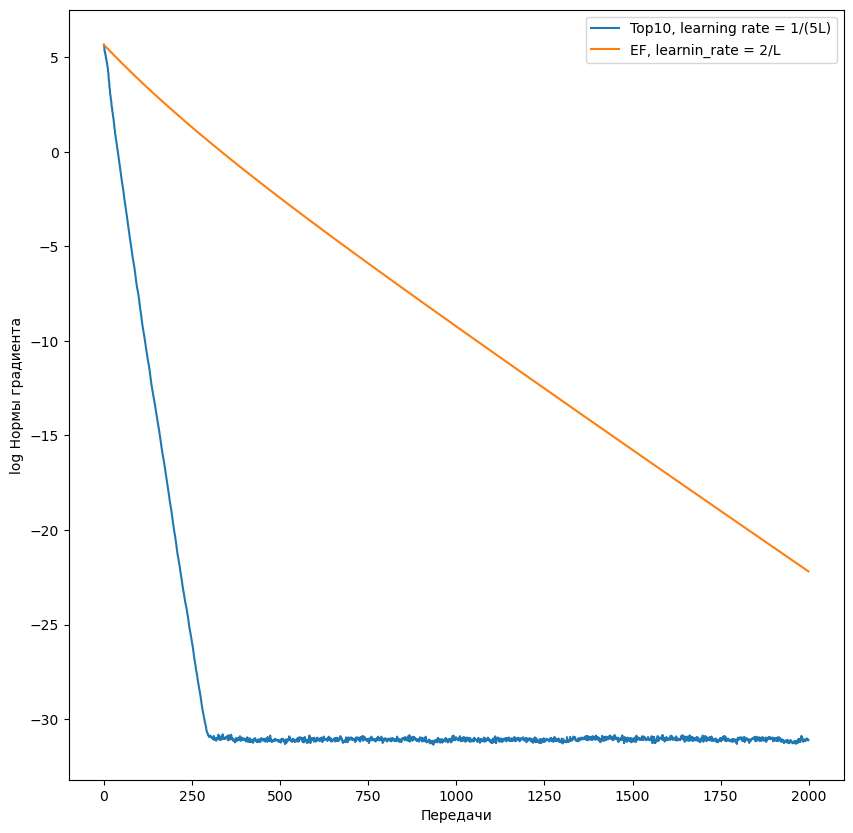

In [7]:
plt.figure(figsize=(10, 10))

iter_number = 2000

criterion2 = []
x = Gradient_descent_Top([0]*d, 1/5/L, iter_number, 10)
plt.plot(range(iter_number), np.log(criterion2)[:iter_number],  label = "Top10, learning rate = 1/(5L)")


criterion3 = []
errors  = np.zeros((n, d))
x = error_feedback([0]*d, 2/L, iter_number, 10)
plt.plot(range(iter_number), np.log(criterion3)[:iter_number],  label = "EF, learnin_rate = 2/L")


plt.legend()

plt.ylabel('log Нормы градиента')
plt.xlabel('Передачи')

Заметно, что $Top10\%$ оказался быстрее

## Задача 2

Рассмотрим задачу логистической регрессии на датасете mushrooms с $\ell_2$-регуляризацией (коэффициент регуляризации равен $\frac{L}{1000}$). 

__(а)__ Симмулируем распределенное решение. Для этого разделите обучающую выборку случайно и равномерно на $n=10$ частей. Каждая такая часть сформирует $f_i$.

In [8]:
from sklearn.datasets import load_svmlight_file
import random as rnd

dataset = "mushrooms.txt"
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
#y = 2 * y - 3
N, d = X.shape

print(N,d)

8124 112


In [9]:

train_index = rnd.sample(range(N), round(4 * N / 5))
test_index = list(set(range(N)) - set(train_index))

X_tr = np.empty((len(train_index), d), dtype=float)
y_tr = np.empty(len(train_index), dtype=float)

X_tst = np.empty((len(test_index), d), dtype=float)
y_tst = np.empty(len(test_index), dtype=float)

k = 0
for i in train_index:
    X_tr[k] = X[i]
    y_tr[k] = 2.0*y[i] - 3.0
    k += 1
    
k = 0    
for i in test_index:
    X_tst[k] = X[i]
    y_tst[k] = 2.0*y[i] - 3.0
    k += 1

batch_size = X_tr.shape[0] // n

X_truncated = X_tr[:n * batch_size, :]
y_truncated = y_tr[:n * batch_size]
X_machines = np.array(np.split(X_truncated, batch_size, axis=0))
y_machines = np.array(np.split(y_truncated, batch_size))

print(np.array(X_machines).shape)
print(np.array(X_machines[:, 0, :]).shape)
print(np.array(y_machines).shape)
print(np.array(y_machines[:, 0]).shape)

eigvals = np.linalg.eigvals(X_tr.T @ X_tr)
L = 1 / 4 / batch_size * max(eigvals).real
print('L = ', L)

(649, 10, 112)
(649, 112)
(649, 10)
(649,)
L =  25.891384768304203


__(б)__ Реализуйте симмуляцию (как в Задаче 1) обычного распределенного градиентного спуска с операторами сжатия, распределенного градиентного спуска с техникой error feedback, алгоритма DIANA (смотри Алгоритм 11 из [статьи](https://arxiv.org/abs/1905.11261)). Сжатия происходят только при пересылке от сервера к устройствам.

In [10]:
def grad_f(X, y, w):
    return (2 * (X.T @ X ) @ w - 2 * X.T @ y) / 10 + L / 500 * w

In [11]:
criterion1 = []
accuracy1 = []
def grad_descent_distr(x_0, learning_rate, iter_number, k):
    x = x_0
    for _ in range(iter_number):
        pos = np.arange(d)
        np.random.shuffle(pos)
        pos = pos[:k]
        grad, criterion =  grad_descent_distr_step(x, learning_rate, iter_number, pos)
            
        x = x - learning_rate * grad 
        criterion1.append(np.linalg.norm(criterion))
        accuracy1.append(np.count_nonzero(np.round(X_tst @ x) == y_tst) / len(y_tst) * 100)
    return x

def grad_descent_distr_step(x, learning_rate, iter_number,pos):
    grad = np.zeros(d)
    criterion = np.zeros(d)
    for i in range(n):
        criterion_i = grad_f(X_machines[: ,i, :], y_machines[:, i], x)
        criterion +=criterion_i
        grad_i = np.zeros(d)
        grad_i[pos] = criterion_i[pos]
        grad += grad_i
    return grad, criterion



criterion3 = []
accuracy3 = []
errors  = np.zeros((n, d))
def error_feedback(x_0, learning_rate, iter_number, k):
    x = x_0
    pos = np.argpartition(x, -k)
    
    for i in range(iter_number):
        grad = np.zeros(d)
        criterion = np.zeros(d)
        
        grad, criterion =  ef_step(x, learning_rate, iter_number, pos)
        
        x = x - learning_rate * grad 
        criterion3.append(np.linalg.norm(criterion))
        accuracy3.append(np.count_nonzero(np.round(X_tst @ x) == y_tst) / len(y_tst) * 100)
    pos = np.argpartition(np.abs(criterion), -k)
    pos = pos[-k:]
    criterion3.append(np.linalg.norm(criterion))
    return x
    
def ef_step(x, learning_rate, iter_number, pos):
    grad = np.zeros(d)
    criterion = np.zeros(d)
    for i in range(n):
        criterion_i = grad_f(X_machines[: ,i, :], y_machines[:, i], x)
        criterion += criterion_i

        grad_i = np.zeros(d)
        grad_i[pos] = (errors[i] + learning_rate* criterion_i)[pos]
        grad += grad_i
        errors[i] = errors[i] + learning_rate * criterion_i - grad_i
    return (grad, criterion)


criterion4 = []
accuracy4 = []
h = np.zeros((n ,d))
def DIANA(x_0, learning_rate, iter_number, k, alpha):
    x = x_0
    for j in range(iter_number):
        crit = np.zeros(d)
        grad = np.zeros(d)
        delta = np.zeros(d)
        pos = np.random.choice(d, k, replace = True)
        for i in range(n):
            gradi = grad_f(X_machines[: ,i, :], y_machines[:, i], x)
            crit += gradi
            
            deltai = gradi - h[i]

            deltai_ = np.zeros(d)
            deltai_[pos] = deltai[pos]

            gradi_ = h[i] + deltai_
            h[i] = h[i] + alpha * deltai_

            grad += gradi_
            delta += deltai_
        x = (x - learning_rate * grad)/(1 + L / 500)
        criterion4.append(np.linalg.norm(grad))
        accuracy4.append(np.count_nonzero(np.round(X_tst @ x) == y_tst) / len(y_tst) * 100)
        #criterion4.append((np.count_nonzero(np.round(X_tst @  x) == y_tst) / len(y_tst) * 100))


In [12]:
criterion11 = []
accuracy11 = []
def grad_descent_distr_Top(x_0, learning_rate, iter_number, k):
    x = x_0
    pos = np.argpartition(np.zeros(d), -k)[-k:]
    for _ in range(iter_number):
        pos = pos[:k]
        grad, criterion =  grad_descent_distr_step_Top(x, learning_rate, iter_number, pos)
            
        x = x - learning_rate * grad 
        criterion11.append(np.linalg.norm(criterion))
        accuracy11.append(np.count_nonzero(np.round(X_tst @ x) == y_tst) / len(y_tst) * 100)
        pos = np.argpartition(np.abs(criterion), -k)[-k:]
    return x

def grad_descent_distr_step_Top(x, learning_rate, iter_number,pos):
    grad = np.zeros(d)
    criterion = np.zeros(d)
    for i in range(n):
        criterion_i = grad_f(X_machines[: ,i, :], y_machines[:, i], x)
        criterion +=criterion_i
        grad_i = np.zeros(d)
        grad_i[pos] = criterion_i[pos]
        grad += grad_i
    return grad, criterion



criterion31 = []
accuracy31 = []
errors  = np.zeros((n, d))
def error_feedback_Top(x_0, learning_rate, iter_number, k):
    x = x_0
    pos = np.argpartition(np.zeros(d), -k)[-k:]
    for i in range(iter_number):
        grad = np.zeros(d)
        criterion = np.zeros(d)
        
        grad, criterion =  ef_step_Top(x, learning_rate, iter_number, pos)
        
        x = x - learning_rate * grad 
        criterion31.append(np.linalg.norm(criterion))
        accuracy31.append(np.count_nonzero(np.round(X_tst @ x) == y_tst) / len(y_tst) * 100)
        pos = np.argpartition(np.abs(criterion), -k)[-k:]
    pos = np.argpartition(np.abs(criterion), -k)
    pos = pos[-k:]
    
    return x
    
def ef_step_Top(x, learning_rate, iter_number, pos):
    grad = np.zeros(d)
    criterion = np.zeros(d)
    for i in range(n):
        criterion_i = grad_f(X_machines[: ,i, :], y_machines[:, i], x)
        criterion += criterion_i

        grad_i = np.zeros(d)
        grad_i[pos] = (errors[i] + learning_rate* criterion_i)[pos]
        grad += grad_i
        errors[i] = errors[i] + learning_rate * criterion_i - grad_i
    return (grad, criterion)


criterion41 = []
accuracy41 = []
h = np.zeros((n ,d))

def DIANA_Top(x_0, learning_rate, iter_number, k, alpha):
    x=x_0
    indices = np.argpartition(x, -k)[-k:]
    h_mas = np.zeros((n, d))
    for j in range(iter_number):
        crit = np.zeros(d)
        grad = np.zeros(d)
        delta = np.zeros(d)
        for i in range(n):
            Xi = X_machines[: ,i, :]
            yi = y_machines[:, i]
            gradi = grad_f(Xi, yi, x)
            crit += gradi

            deltai = gradi - h_mas[i]

            deltai_ = np.zeros(d)
            deltai_[indices] = deltai[indices]

            gradi_ = h_mas[i] + deltai_
            h_mas[i] = h_mas[i] + alpha*deltai_

            grad += gradi_
            delta += deltai_
        x = (x - learning_rate * grad)/(1 + L / 500)
        criterion41.append(np.linalg.norm(crit))
        accuracy41.append(np.count_nonzero(np.round(X_tst @ x) == y_tst) / len(y_tst) * 100)
        
        absolute = np.abs(crit)
        indices = np.argpartition(absolute, -k)[-k:]
        
    return x

__(в)__ Используйте операторы сжатия $\text{Top}10\%$ и $\text{Rand}10\%$ во всех трех методах (всего получается 6 разных подходов). Для каждого подхода подберите шаг $\gamma$ для наилучшей сходимости, постройте 2 сравнительных графика сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$ или точность предсказаний, а по оси $x$ - число итераций/коммуникаций). Сделайте вывод.

Text(0.5, 0, 'Номар шага')

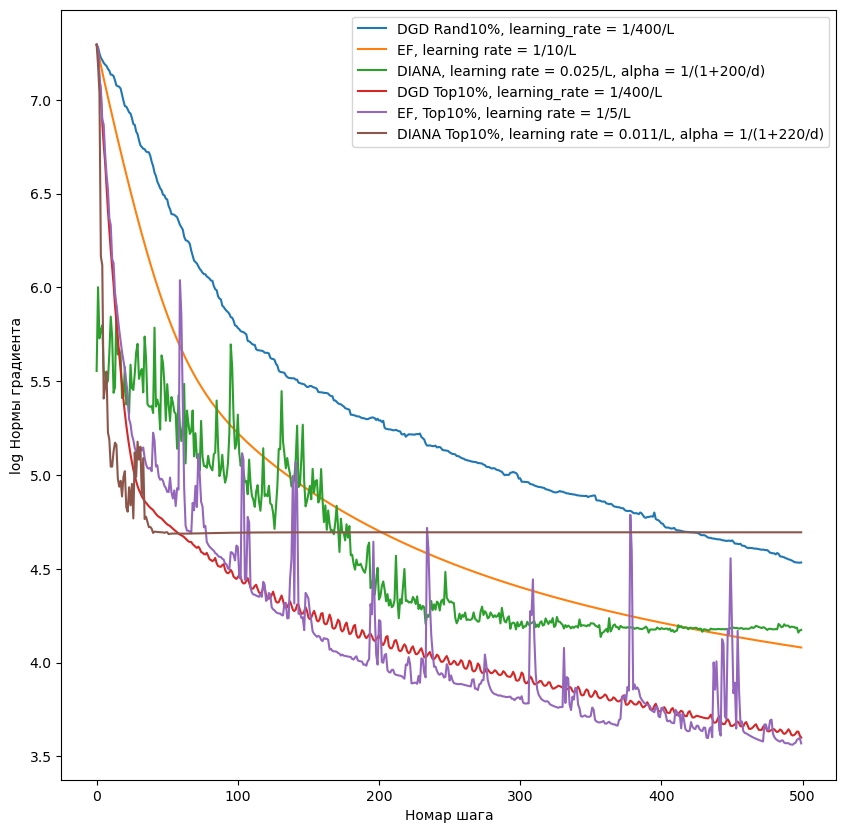

In [13]:
plt.figure(figsize=(10, 10))

iter_number = 500

criterion1 = []
x = grad_descent_distr(np.zeros(d), 1/400/L, iter_number, 10)
plt.plot(range(iter_number), np.log(criterion1),  label = f'DGD Rand10%, learning_rate = 1/400/L')

criterion3 = []
errors  = np.zeros((n, d))
x = error_feedback(np.zeros(d), 1/10/L, iter_number, 10)
plt.plot(range(iter_number), np.log(criterion3)[:iter_number],  label = "EF, learning rate = 1/10/L")

criterion4 = []
h = np.zeros((n ,d))
x = DIANA(np.zeros(d), 0.025/L, iter_number, 10,  1/(1+200/d))
plt.plot(range(iter_number), np.log(criterion4)[:iter_number],  label = "DIANA, learning rate = 0.025/L, alpha = 1/(1+200/d)")

criterion11 = []
x = grad_descent_distr_Top(np.zeros(d), 1/400/L, iter_number, 10)
plt.plot(range(iter_number), np.log(criterion11),  label = f'DGD Top10%, learning_rate = 1/400/L')

criterion31 = []
errors  = np.zeros((n, d))
x = error_feedback_Top(np.zeros(d), 1/5/L, iter_number, 10)
plt.plot(range(iter_number), np.log(criterion31)[:iter_number],  label = "EF, Top10%, learning rate = 1/5/L")

criterion41 = []
h = np.zeros((n ,d))
x = DIANA_Top(np.zeros(d), 0.011/L, iter_number, 10,  1/(1+220/d))
plt.plot(range(iter_number), np.log(criterion41)[:iter_number],  label = "DIANA Top10%, learning rate = 0.011/L, alpha = 1/(1+220/d)")








plt.legend()

plt.ylabel('log Нормы градиента')
plt.xlabel('Номар шага')

Text(0.5, 0, 'Номер шага')

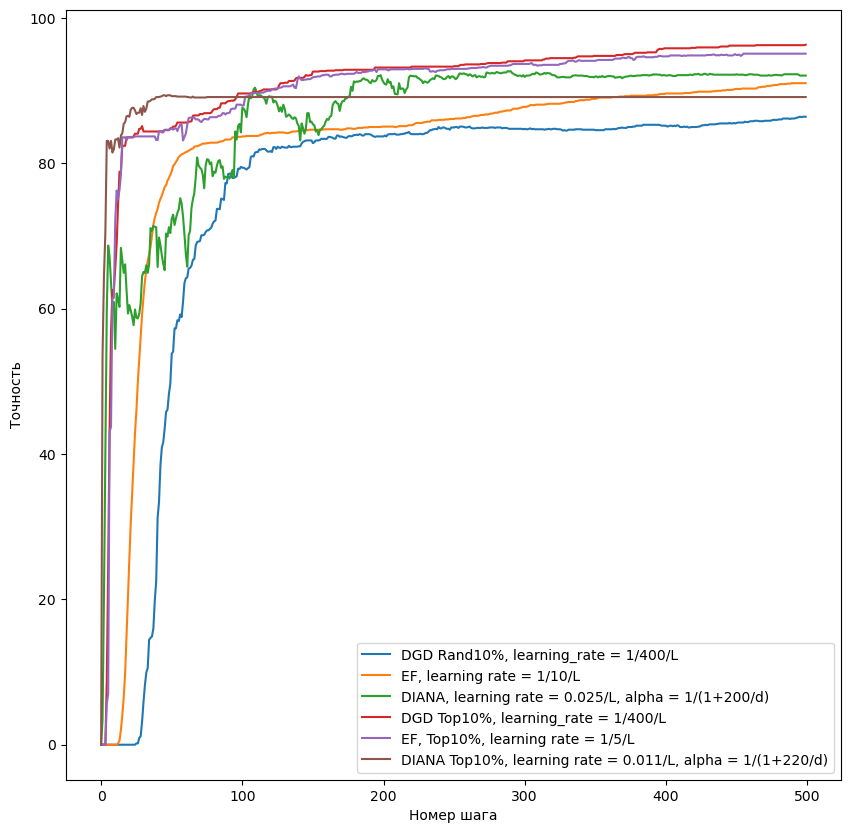

In [14]:
plt.figure(figsize=(10, 10))

iter_number = 500

plt.plot(range(iter_number), accuracy1,  label = f'DGD Rand10%, learning_rate = 1/400/L')

plt.plot(range(iter_number), accuracy3[:iter_number],  label = "EF, learning rate = 1/10/L")

plt.plot(range(iter_number), accuracy4[:iter_number],  label = "DIANA, learning rate = 0.025/L, alpha = 1/(1+200/d)")

plt.plot(range(iter_number), accuracy11,  label = f'DGD Top10%, learning_rate = 1/400/L')

plt.plot(range(iter_number), accuracy31[:iter_number],  label = "EF, Top10%, learning rate = 1/5/L")

plt.plot(range(iter_number), accuracy41[:iter_number],  label = "DIANA Top10%, learning rate = 0.011/L, alpha = 1/(1+220/d)")







plt.legend()

plt.ylabel('Точность')
plt.xlabel('Номер шага')

Error feedback для top 10% оказался быстрее всех предложенных алгоритмов. В целом top10% лучше rand 10%.


__Бонусные пункты__

__(г)__ Реализуйте два метода: [EF21](https://proceedings.neurips.cc/paper/2021/hash/231141b34c82aa95e48810a9d1b33a79-Abstract.html) и [MARINA](https://arxiv.org/abs/2102.07845). Добавьте их к сравнительному анализу из пункта (в) (здесь важно обратить внимание на особенности алгоритма MARINA и отразить это в анализе). Сделайте вывод. 

In [15]:
#ответ

__(д)__ Добавьте в лучшие 3 (на Ваш взгляд) метода (обычный GD с оператором сжатия, GD с EF, DIANA, EF21, MARINA) возможность сжимать и при передаче от сервера к устройству. Для сжатия используйте только $\text{Top}10\%$ и $\text{Rand}10\%$. Проведите серию экспериментов и ответьте на следующие пункты:

1) Если при сжатии на сервере используются $\text{Top}10\%$ нужно ли использовать технику компесации ошибки на сервере? Опишите, как добавляли еe в метод (лучший вариант - выписать алгоритм частично или целиком). 

2) Перебирая разные комбинации из операторов $\text{Top}10\%$ и $\text{Rand}10\%$ для сжатия на сервера и на устройствах, найдите лучшую конфигурацию операторов сжатия для каждого метода.

3) Какой метод и с каким операторами показал в итоге лучшие результаты? Использовался ли при этом дополнительный error feedback на сервере? 

In [16]:
#ответ